# Functional connectivity between subjects (ISFC)

- Use the `levels_betas.npy` data

see the [brainiak tutorial isc - 10](https://brainiak.org/tutorials/10-isc/) for more info

> The goal of ISFC is to find coupling between brain regions across participants. For example the angular gyrus in subject 1 could be correlated to the pre-frontal cortex in subject 2, if they share some cognitive state. For completely random cognitive states across these two subjects, the correlation should be zero. ISFC helps us identify such commonalities across subjects.

from [Hasson Lab](https://www.hassonlab.com/inter-subject-functional)

> The inter-subject functional coherence (ISFC) differs from standard FC analysis in one crucial way: it is calculated *across brains* rather than within brains. The ISFC method provides a novel way to isolate the stimulus-locked response component of each functional network, by correlating the response timecourse across brains.

The ISFC method allows us to track the stimulus-locked brain processes within a network during the processing of real-life stimuli and to study the dynamical evolution of network architectures during real-life information processing.

See also [(Simony et al., 2016)](https://b0e95918-69fa-461c-8a44-239d3f2b4c80.filesusr.com/ugd/b75639_92eab30b43284ca0bd163e3daa709eda.pdf) for more info


![](https://static.wixstatic.com/media/b75639_39011daec8674fad91e66441441bc367.jpg/v1/fill/w_576,h_437,al_c,q_80,usm_0.66_1.00_0.01/b75639_39011daec8674fad91e66441441bc367.webp)


In [1]:
import warnings
import sys 
if not sys.warnoptions:
    warnings.simplefilter("ignore")
import os 
import glob
import time
from copy import deepcopy
import numpy as np
import pandas as pd 

from nilearn import datasets
from nilearn import surface
from nilearn import plotting
from nilearn.input_data import NiftiMasker, NiftiLabelsMasker
import nibabel as nib

from brainiak import image, io
from brainiak.isc import isc, isfc, permutation_isc
import matplotlib.pyplot as plt
import seaborn as sns 
import utils
from scipy import stats
from importlib import reload 

%autosave 5
%matplotlib inline
sns.set(style = 'white', context='talk', font_scale=1, rc={"lines.linewidth": 2})

Autosaving every 5 seconds


In [2]:
# specify local path
path = '/Users/Daphne/data/'

# parameters
num_subjects = 8

# Betas
levels_betas = np.load(path+'bold_data_levels.npy')

# load mask and get voxel coordinates
mask_arr = np.load(path+'mask_arr.npy') # all masks are the same
mask_mat = mask_arr[0] # so we can pick any one from the array
coords_mat = np.array(np.where(mask_mat == 1)) # so need one set of voxel coordinates for all
coords_mat[[0, 2]] = coords_mat[[2, 0]] # exchange the rows

'''load brain templates'''

# mask_nii is the functional mask, this selects the brain voxels
mask_nii = nib.load(os.path.join(path, 'mask.nii')) 

# we get the brain mask (boolean array) with the .dataobj method
brain_mask = np.array(mask_nii.dataobj)

# Get the list of nonzero voxel coordinates from the nii mask
coords_nii = np.where(brain_mask)

# this where we plot our mask ON (sometimes called brain_nii) - the anatomical/structural image
mean_nii = nib.load(os.path.join(path, 'mean.nii')) 

# nosmooth betas mask, has less voxels than mask_nii
nosmooth_mask_nii = nib.load(os.path.join(path, 'mask_nosmooth.nii'))

from nibabel.affines import apply_affine
from numpy.linalg import inv
# inverse of the affine matrix: mni2cor
inv_affine = inv(mask_nii.affine) # get the transformation matrix

In [3]:
len(levels_betas[0,:,0])

220075

# 1 Temporal ISFC

## 1.1 Get the mni coordinates from Momchil and own analysis

In [4]:
# taking voxels from the find_ROIs notebook
mni_coords_roi1A = [48, 34,  8]
mni_coords_roi1B = [-45, 22, 22]
mni_coords_roi2 = [28, -66, 10]
mni_coords_roi3 = [20, -92, -10]
mni_coords_roi4 = [-6, 26, 44]
mni_coords_roi5 = [-4, 36, 10]
mni_coords_roi6 = [10, 8, -18]

In [5]:
# Theory encoding voxels
R_IFG_Tri_E = [42, 28, 26]
L_Insula_E = [-30, 28, 2]
R_DMPFC_E = [6, 38, 40]
L_IFG_Tri_E = [-50, 44, 12]
L_MTG_E = [-64, -50, 4]
R_MTG_E = [58, -36, 8]

In [6]:
# Theory updating voxels
R_IFG_Oper_U = [48, 12, 28]
L_PPC_U = [-56, -32, 46]
R_IFG_Tri_U = [52, 38, 16]
R_AG_U = [32, -60, 34]
L_Fusiform_U = [-40, -58, -12]
L_IFG_Oper_U = [-42, 4, 28]
R_PHC_U = [26, -42, -8]

In [7]:
# create mapping between roi name and mni coordinates
roi_dict_momchil = {'R_IFG_Tri_E':R_IFG_Tri_E, 'L_Insula_E':L_Insula_E, 'R_DMPFC_E':R_DMPFC_E,
            'L_IFG_Tri_E':L_IFG_Tri_E, 'L_MTG_E':L_MTG_E, 'R_MTG_E':R_MTG_E,
            'R_IFG_Oper_U':R_IFG_Oper_U, 'L_PPC_U':L_PPC_U, 'R_IFG_Tri_U':R_IFG_Tri_U,
            'R_AG_U':R_AG_U, 'L_Fusiform_U':L_Fusiform_U, 'L_IFG_Oper_U':L_IFG_Oper_U, 
            'R_PHC_U':R_PHC_U}

roi_dict_daph = {'roi_1_A':[48, 34,  8], 'roi_1_B':[-45, 22, 22], 'roi_2':[28, -66, 10], 
                 'roi_3':[20, -92, -10], 'roi_4':[-6, 26, 44], 'roi_5':[-4, 36, 10], 
                 'roi_6':[10, 8, -18]}

# combine in one
all_dict = {**roi_dict_momchil, **roi_dict_daph}

In [8]:
all_dict

{'R_IFG_Tri_E': [42, 28, 26],
 'L_Insula_E': [-30, 28, 2],
 'R_DMPFC_E': [6, 38, 40],
 'L_IFG_Tri_E': [-50, 44, 12],
 'L_MTG_E': [-64, -50, 4],
 'R_MTG_E': [58, -36, 8],
 'R_IFG_Oper_U': [48, 12, 28],
 'L_PPC_U': [-56, -32, 46],
 'R_IFG_Tri_U': [52, 38, 16],
 'R_AG_U': [32, -60, 34],
 'L_Fusiform_U': [-40, -58, -12],
 'L_IFG_Oper_U': [-42, 4, 28],
 'R_PHC_U': [26, -42, -8],
 'roi_1_A': [48, 34, 8],
 'roi_1_B': [-45, 22, 22],
 'roi_2': [28, -66, 10],
 'roi_3': [20, -92, -10],
 'roi_4': [-6, 26, 44],
 'roi_5': [-4, 36, 10],
 'roi_6': [10, 8, -18]}

## 1.2 Select voxels from levels betas

In [9]:
# get the voxels for all corresponding voxels above for later
roi_voxel_indices = []

for key, value in roi_dict_momchil.items():

    coords_mni = value
    print(coords_mni)
    
    coords_natv = apply_affine(aff=inv_affine, pts=coords_mni) # from mni2cor
    vox_num = utils.get_vox_from_coords(coords_mat, coords_natv) # corresponding voxel
    
    roi_voxel_indices.append(vox_num)

# =====

for key, value in roi_dict_daph.items():

    coords_mni = value
    print(coords_mni)
    
    coords_natv = apply_affine(aff=inv_affine, pts=coords_mni) # from mni2cor
    vox_num = utils.get_vox_from_coords(coords_mat, coords_natv) # corresponding voxel
    
    roi_voxel_indices.append(vox_num)

[42, 28, 26]
The coordinates correspond to voxel: 146217.
[-30, 28, 2]
The coordinates correspond to voxel: 89655.
[6, 38, 40]
The coordinates correspond to voxel: 175423.
[-50, 44, 12]
The coordinates correspond to voxel: 114273.
[-64, -50, 4]
The coordinates correspond to voxel: 91966.
[58, -36, 8]
The coordinates correspond to voxel: 102081.
[48, 12, 28]
The coordinates correspond to voxel: 150132.
[-56, -32, 46]
The coordinates correspond to voxel: 184359.
[52, 38, 16]
The coordinates correspond to voxel: 123560.
[32, -60, 34]
The coordinates correspond to voxel: 160565.
[-40, -58, -12]
The coordinates correspond to voxel: 53783.
[-42, 4, 28]
The coordinates correspond to voxel: 149930.
[26, -42, -8]
The coordinates correspond to voxel: 63462.
[48, 34, 8]
The coordinates correspond to voxel: 104340.
[-45, 22, 22]
The coordinates correspond to voxel: 137098.
[28, -66, 10]
The coordinates correspond to voxel: 105967.
[20, -92, -10]
The coordinates correspond to voxel: 57453.
[-6, 26,

In [10]:
levels_betas.shape

(54, 220075, 8)

In [11]:
# select only the voxels from roi's
roi_betas = levels_betas[:, roi_voxel_indices, :]

roi_betas.shape # n_TRs, voxels, subjects

(54, 20, 8)

## 1.3 Compute ISFC

To emphasize, the difference between FC (functional connectivity) vs. ISFC (intersubject functional connectivity)
- FC: within individuals
- ISFC: between individuals

---

From Methods section (p.11) [(Simony et al., 2016)](https://b0e95918-69fa-461c-8a44-239d3f2b4c80.filesusr.com/ugd/b75639_92eab30b43284ca0bd163e3daa709eda.pdf)

> Seed-based ISFC is the Pearson correlation between a time course extracted from one region in subject $X$ and all other regions in subject $Y$.


*Seed-based ISFC*. Seed-based ISFC is a special case of network-based ISFC: it is
the Pearson correlation between the response time course in one brain region in
one subject and the average response time courses in all voxels of all other subjects.
Hence, seed-based ISFC is a one-dimensional correlation map of length $p$ (that is, it
is a single row of the $p \times p$ ISFC matrix).


[Brainiak implements the ISFC analysis](https://brainiak.org/docs/brainiak.html#module-brainiak.isc) as specified in (Simony et al., 2016)

    - For each input voxel or ROI, compute the Pearson correlation between each subject’s response time series and all input voxels or ROIs in other subjects.
    - If pairwise is False (default), use the leave-one-out approach, where correlation is computed between each subject and the average of the other subjects. (If pairwise is True, compute correlations between all pairs of subjects)
    - Alternatively, use either ‘mean’ or ‘median’ to compute summary statistic of ISFCs (Fisher Z is applied if using mean).

In [12]:
# compute the isc correlations using the leave one out approach
isfc_maps = isfc(data=roi_betas, targets=roi_betas, pairwise=True, vectorize_isfcs=False, tolerate_nans=True)

In [13]:
isfc_maps.shape

(8, 20, 20)

## 2.1 Do a ttest 

---

`stats.ttest_1samp` replicates the matlab [ttest(x) function](https://www.mathworks.com/help/stats/ttest.html#btrj1bc):
(One-sample t-test)

- $H_0$: data in x comes from a normal distribution with mean equal to zero (`popmean=0`) and unknown variance, using the one-sample t-test.
- $H_A$: population distribution does not have a mean equal to zero. The result h is 1 if the test rejects the null hypothesis at the 5% significance level, and 0 otherwise.

---

In [14]:
# lets do a ttest to collapse them into a single matrix
ISFC_tstats, ISFC_p = stats.ttest_1samp(np.arctanh(isfc_maps), popmean=0) # do the ttest

In [15]:
ISFC_tstats

array([[ 3.82637801e+00,  2.83350037e+00,  2.85351893e+00,
         2.42850483e+00,  2.92094187e+00,  7.03885436e-01,
         1.91449085e+00,  7.46175124e-01,  7.91914483e-01,
         1.33423853e-01,  1.93112574e+00,  2.56840345e+00,
        -2.89143667e-01,  2.08281192e+00,  3.64638959e+00,
        -3.29334725e-01,  1.18328209e+00,  2.22159214e+00,
         2.07044481e+00,  1.49596976e+00],
       [ 3.50729070e+00,  4.15122503e+00,  4.61597583e+00,
         2.76986280e+00,  1.02913847e+00,  1.72180745e+00,
         2.13025350e+00, -1.85820745e-01,  2.80133845e+00,
        -4.78610152e-01,  2.51864918e+00,  1.57625089e+00,
         6.65410980e-01,  5.89528266e+00,  3.46297336e+00,
        -4.46287608e-01,  8.04377748e-01,  3.58742175e+00,
         4.63120175e+00,  2.41855255e+00],
       [ 1.93214433e+00,  1.81706071e+00,  1.60783489e+00,
         1.44916488e+00,  7.82290366e-01,  3.73605991e-01,
         3.03733405e-01, -3.42229589e-02,  5.18230468e-01,
        -2.21798243e+00,  9.1

In [16]:
ISFC_tstats.shape

(20, 20)

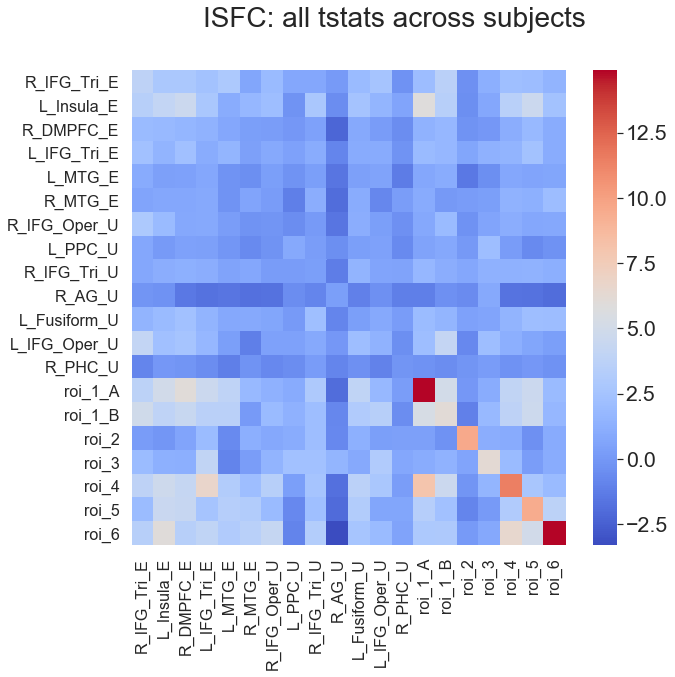

In [17]:
f, ax = plt.subplots(1,1, figsize = (10, 9), dpi=70)
sns.set(font_scale=2)
sns.heatmap(ISFC_tstats, 
            cmap='coolwarm',
            xticklabels=all_dict.keys(),
            yticklabels=all_dict.keys(),
            axes=ax,
            );

f.suptitle('ISFC: all tstats across subjects');

In [18]:
ISFC_sig = utils.get_significant_stats(pvalues=ISFC_p, tstats=ISFC_tstats, alpha=0.01)

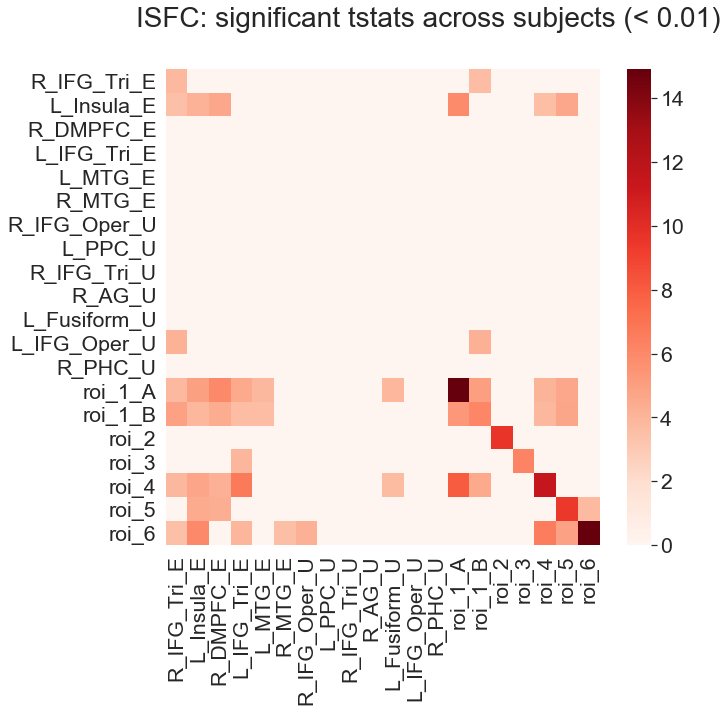

In [19]:
f, ax = plt.subplots(1,1, figsize = (10, 9), dpi=70)
sns.set(font_scale=2)
sns.heatmap(ISFC_sig, 
            cmap='Reds',
            xticklabels=all_dict.keys(),
            yticklabels=all_dict.keys(),
            axes=ax,
            );

f.suptitle('ISFC: significant tstats across subjects (< 0.01)');

In [37]:
def map_vox_on_brain(mean_nii, mask_nii, mni_coords1, mni_coords2, voxel=None):
	'''
	Maps a given voxel on the anatomical brain image using the mni coords.
	'''


	mni_coords1 = np.array(mni_coords1)
	mni_coords2 = np.array(mni_coords2)

	zeros_vol = np.zeros(mask_nii.shape)

	zeros_nifti = nib.Nifti1Image(zeros_vol, mask_nii.affine, mask_nii.header)

	vox_map = plotting.plot_stat_map(stat_map_img=zeros_nifti, bg_img=mean_nii, 
	                            black_bg=False, cut_coords=mni_coords2, 
	                            title=f'');

	# reshape mni coordinates to add the markers 
	mni_coords_rs1 = mni_coords1.reshape(1,3)
	mni_coords_rs2 = mni_coords2.reshape(1,3)

	# Add marker
	vox_map.add_markers(
	    marker_coords=mni_coords_rs1, 
	    marker_color='lawngreen',
	    marker_size=50,
	)
    
	# Add marker
	vox_map.add_markers(
	    marker_coords=mni_coords_rs2, 
	    marker_color='r',
	    marker_size=50,
	)

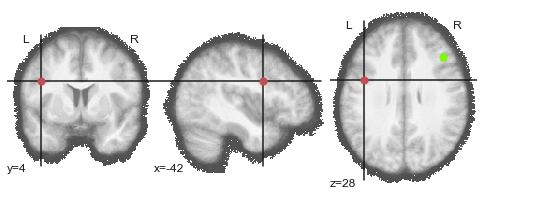

In [38]:
# Theory encoding voxels
R_IFG_Tri_E = [42, 28, 26]
L_IFG_Oper_U = [-42, 4, 28]

# plot the mni coords on brain to show location of ROI
map_vox_on_brain(mean_nii, mask_nii, mni_coords1=R_IFG_Tri_E, mni_coords2=L_IFG_Oper_U)